In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import pmdarima as pm
import saxpy
import nltk
from nltk import bigrams
from nltk import trigrams
from saxpy.sax import sax_via_window
from saxpy.sax import sax_via_window
from saxpy.alphabet import cuts_for_asize
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn import preprocessing as pp

sns.set(rc={'figure.figsize':(11.7,8.27)})

## Reading the datasets

df1 = pd.read_csv("data/BATADAL_dataset03.csv")
df2 = pd.read_csv("data/BATADAL_dataset04.csv")
df2.columns = df2.columns.str.replace(" ", "")
dftest = pd.read_csv("data/BATADAL_test_dataset.csv")

In [5]:
## Add the right attack flags
new_attack_df2 = df2[['DATETIME', 'ATT_FLAG']].copy().set_index("DATETIME")
new_attack_df2['ATT_FLAG'] = 0

attack_points = [
    ["13/09/16 23", "16/09/16 00"],
    ["26/09/16 11", "27/09/16 10"],
    ["09/10/16 09", "11/10/16 20"],
    ["29/10/16 19", "02/11/16 16"],
    ["26/11/16 17", "29/11/16 04"],
    ["06/12/16 07", "10/12/16 04"],
    ["14/12/16 15", "19/12/16 04"]
]

for attack_point in attack_points:
    new_attack_df2.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df2.reset_index(inplace=True)

new_attack_df_test = dftest[['DATETIME']].copy().set_index("DATETIME")
new_attack_df_test['ATT_FLAG'] = 0

attack_points = [
    ["16/01/17 09", "19/01/17 06"],
    ["30/01/17 08", "02/02/17 00"],
    ["09/02/17 03", "10/02/17 09"],
    ["12/02/17 01", "13/02/17 07"],
    ["24/02/17 05", "28/02/17 08"],
    ["10/03/17 14", "13/03/17 21"],
    ["25/03/17 20", "27/03/17 01"]
]

for attack_point in attack_points:
    new_attack_df_test.loc[attack_point[0]:attack_point[1], 'ATT_FLAG'] = 1
    
new_attack_df_test.reset_index(inplace=True)

df2['ATT_FLAG'] = new_attack_df2['ATT_FLAG']
dftest['ATT_FLAG'] = new_attack_df_test['ATT_FLAG']

In [6]:
def predict_ARMA(training_features, test_features):
    ## Loading the target_model parameters
    filename = "target_models.obj"
    file_to_read = open(filename, 'rb')
    target_models = pickle.load(file_to_read)
    
    window_width = 1000
    data_streams =  training_features.loc[len(training_features):,which_columns].reset_index(drop=True)
    params = target_models['params']

    trained_models = []

    predictions = pd.DataFrame(columns=which_columns)
    # len(target_df),
    for i in range(0, len(test_features)-window_width, window_width): 
        ## Create the new models
        data_streams = data_streams.append(test_features.loc[i:i+window_width-1, which_columns],ignore_index=True)
        data_stream = test_features.loc[i:i+window_width-1, which_columns]
        trained_models = []

        new_predictions = pd.DataFrame(columns=which_columns)

        print("Training up until " + str(i+window_width))
        for column in which_columns:
            try:
                trained_model = pm.ARIMA(order=target_models.loc[column, 'order'], seasonal_order=(0,0,0,1), start_params=params[column], suppress_warnings=True)
            except:
                trained_model = pm.ARIMA(order=target_models.loc[column, 'order'], seasonal_order=(0,0,0,1), suppress_warnings=True)
            trained_model.fit(data_stream[column])
            trained_models.append(trained_model)
            new_predictions[column] = trained_model.predict(window_width)

        new_predictions.index = range(i+window_width,i+window_width+window_width)
        predictions = predictions.append(new_predictions)
        
    new_predictions = predictions
    new_predictions = new_predictions.append(target_df.loc[:min(new_predictions.index), which_columns], sort=True)
    new_predictions = new_predictions.sort_index()
    new_predictions = new_predictions.iloc[0:len(target_df), :]

    errors = ((target_df[which_columns] - new_predictions[which_columns])**2).sum(axis=1)
    threshold = 12
    output = errors>threshold
    return output

In [7]:
def discretize(original_signal, paa_size=3, window_size=2, amount_of_levels=3):
    sax1 = sax_via_window(original_signal, window_size, paa_size, amount_of_levels)
    indices = []
    for k, v in sax1.items():
        indices.extend(v)
    indices.sort()
    discrete_signal = pd.DataFrame(index=indices, columns=["word"])
    for k, v in sax1.items():
        discrete_signal.loc[v] = k
    return discrete_signal

def get_trigram(discrete_signal):
    ts_string = " ".join(discrete_signal['word'])
    tokens = nltk.word_tokenize(ts_string)
    tri_tokens = trigrams(tokens)
    tri_list = [tuple(trigram) for trigram in tri_tokens]
    fdist = nltk.FreqDist(tri_list)
    trigram_df = pd.DataFrame.from_dict(fdist,orient='index')
    trigram_df_prob = trigram_df/trigram_df.sum()    
    try:
        return pd.Series(tri_list, index=discrete_signal.index[:-2]), trigram_df_prob[0]
    except:
        return None, None
    
def predict_Discrete(training_features, test_features):
    target_columns = ['F_PU6', 'S_PU6', 'F_PU11', 'S_PU11', 'F_PU7', 'S_PU7', 'P_J302',
       'P_J14', 'P_J307', 'L_T4', 'P_J317', 'L_T1', 'F_PU1', 'P_J269',
       'F_PU10', 'F_V2', 'S_PU10', 'P_J422', 'S_PU2']
        
    paa_size=3
    window_size=5
    amount_of_levels=3
    min_triggers = 3
    trigger_is_0 = False

    alert_sum = []
    for target in target_columns:
        dat1 = training_features[target].values
        tris, triprob = get_trigram(discretize(dat1,paa_size,window_size,amount_of_levels))

        dat2 = test_features[target].values
        tris2, tris2prob = get_trigram(discretize(dat2,paa_size,window_size,amount_of_levels))

        if (triprob is None) and (tris2prob is None):
            continue
        
        if trigger_is_0:
            threshold = 0
        else: 
            threshold = min(triprob)
        
        if len(alert_sum) == 0:
            results = (tris2.apply(lambda x: triprob.get(x, -1))<=threshold).astype(int)
            alert_sum = results
        else:
            try:
                results = (tris2.apply(lambda x: triprob.get(x, -1))<=threshold).astype(int)
                alert_sum = alert_sum.add(results, fill_value=0)
            except:
                continue
                
    predictions = alert_sum >= min_triggers
    predictions = predictions.reindex(range(max(predictions.index))).ffill()
    return predictions

In [8]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def pcatest(n_components, traindata, testdata):
    pca = PCA(n_components=n_components)

    X_train_PCA = pca.fit_transform(traindata)
    X_test_PCAd = pd.DataFrame(data=pca.transform(testdata), index=testdata.index)

    X_test_PCAd_inverse = pca.inverse_transform(X_test_PCAd)
    X_test_PCAd_inverse = pd.DataFrame(data=X_test_PCAd_inverse, index=testdata.index)
    return X_test_PCAd_inverse,X_test_PCAd

def predict_PCA(training_features, test_features):
    n_components = 4
    
    X_test_PCAd_inverse, X_test_PCAd = pcatest(n_components,training_features,test_features)
    anomalyScoresPCA = anomalyScores(test_features, X_test_PCAd_inverse)
    
    threshold = 0.3
    return anomalyScoresPCA > threshold

In [9]:
def print_stats(target_labels, predictions):
    correct = target_labels.eq(predictions)

    truePositives = sum(correct[target_labels==1])
    trueNegatives = sum(correct[target_labels==0])
    falsePositives = sum((~correct)[target_labels==0])
    falseNegatives = sum((~correct)[target_labels==1])

    print("Recall: " + str(truePositives / (truePositives + falseNegatives)))
    print("Precision: " + str(truePositives / (truePositives + falsePositives)))
    print("TP: " + str(truePositives))
    print("TN: " + str(trueNegatives))
    print("FP: " + str(falsePositives))
    print("FN: " + str(falseNegatives))


In [10]:
without_att_train_df = df2[df2["ATT_FLAG"]==0].drop(columns=["DATETIME", "ATT_FLAG"])
train_df = df2.drop(columns=["DATETIME", "ATT_FLAG"])

test_df = dftest.drop(columns=["DATETIME", "ATT_FLAG"])
train_labels = df2['ATT_FLAG']
test_labels = dftest['ATT_FLAG']

Recall: 0.14250614250614252
Precision: 1.0
TP: 58
TN: 1682
FP: 0
FN: 349


[Text(0.5, 1.0, 'PCA method predictions')]

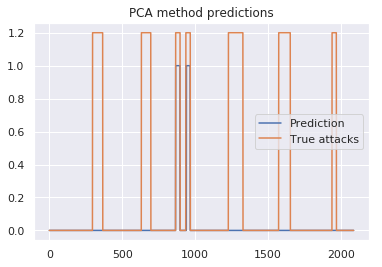

In [11]:
## PCA predictions
PCA_predictions = predict_PCA(without_att_train_df, test_df)

print_stats(test_labels, PCA_predictions)

fig, ax = plt.subplots()
sns.lineplot(data=PCA_predictions, ax=ax)
sns.lineplot(data=test_labels*1.2, ax=ax)
ax.legend(["Prediction", "True attacks"])
ax.set(title="PCA method predictions")

In [ ]:
## Discrete predictions
Discrete_predictions = predict_Discrete(without_att_train_df, test_df)

print_stats(test_labels, Discrete_predictions)

fig, ax = plt.subplots()
sns.lineplot(data=Discrete_predictions, ax=ax)
sns.lineplot(data=test_labels*1.2, ax=ax)
ax.legend(["Prediction", "True attacks"])
ax.set(title="Discrete method predictions")

In [ ]:
## ARMA predictions
ARMA_predictions = predict_ARMA(without_att_train_df, test_df)

print_stats(test_labels, ARMA_predictions)

fig, ax = plt.subplots()
sns.lineplot(data=Discrete_predictions, ax=ax)
sns.lineplot(data=test_labels*1.2, ax=ax)
ax.legend(["Prediction", "True attacks"])
ax.set(title="ARMA method predictions")